## Calculo del delay del retardador a partir de la fuente de iluminacion medida

**Autor**: Jesús del Hoyo

**Fecha**:   01/10/2018

**Objetivo**: Ecograb project, polariscope callibration

**Explicación**:

Necesito encontrar por qué la descomposición da un valor de delay erroneo.

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from __future__ import print_function

import time
import pprint

from numpy import array, matrix, matmul, power, sum, size, zeros
from math import sin, cos, pi, sqrt
from cmath import exp

from phyton_optics import degrees , sp, plt

from scipy import optimize
from scipy.io import loadmat

from polarimeter.utils import plot_experiment_residuals_1D, plot_2d, clean_intensity
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_jones import rotation
from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller, polarized_light
from polarimeter.utils import dibujar_2d_fitting, generate_even_distribution, plot_2d_scattered, plot_2d


from polarimeter.polarimeter import Intensity_Rotating_Elements
import phyton_optics.polarization_jones as pj
import phyton_optics.polarization_stokes as ps
import phyton_optics.polarization_mueller_analysis as amm
import polarimeter.polarimeter as opsys
import numpy as np
import os

## Cargar datos

** Fit parameters **

In [28]:
# Already characterized elements
(p11,p12, delay1) = (0.962421338047, 0.0723017114037, 109.674226344*degrees)
(p21, p22) = (0.974429083571, 0.0933985896782)
#th0p1 = (122.449494104 + 125.992)*degrees #
th0p1 = (122.449494104 + 0)*degrees #
#th0p2 = (104.736748578 + 135.633)*degrees # + 135.633
th0p2 = (104.736748578 + 0)*degrees
th0p1ad = 4.49058478366*degrees
parR1 = [1.00633931598, 1.01339903131, 84.6008729373*degrees]
th0r1 = 175.571888512*degrees
th0r1ad = 9.1554487636*degrees
parR2 = [0.932112996884, 0.936748373013, 81.6800679199*degrees]
th0r2 = 2.78054116251*degrees
Jp1 = ps.Mueller_Real_Retarder(p11, p12, delay1)
Jp2 = ps.polarizer_linear(p21, p22)
Jr1 = ps.Mueller_Real_Retarder(parR1[0], parR1[1], parR1[2])
Jr2 = ps.Mueller_Real_Retarder(parR2[0], parR2[1], parR2[2])
M = [Jp1, Jr1, Jr2, Jp2]
th0 = [th0p1+th0p1ad, th0r1+th0r1ad, th0r2, th0p2]
Ifuente = np.matrix(np.array([[5.86922518], [0.56906085], [-0.25053408], [5.83619796]]))

In [50]:
intensity_0 = np.array([-0.0243, 0.0217])
# Load file, Illumination maximum
filename = 'Intensidad_max_2018-10-01.npz'
data = np.load(filename)
# Rename variables
Iindividual = data['Iindividual']
Naverage = data['Naverage']
# Make stadistics
mean = np.mean(Iindividual, axis=0)
print(mean)

[5.9535574 4.2471744]


## Simular el experimento de las dos maneras posibles y comparar

Muestra
[[ 0.9409      0.          0.          0.        ]
 [ 0.          0.93512784  0.04107103  0.09561327]
 [ 0.          0.04107103  0.64866445 -0.68032376]
 [ 0.         -0.09561327  0.68032376  0.64289229]]
Calculada
[[ 0.9409      0.         -0.         -0.        ]
 [ 0.          0.93512784  0.04107103  0.09561327]
 [ 0.          0.04107103  0.64866445 -0.68032376]
 [ 0.         -0.09561327  0.68032376  0.64289229]]
Delays calculados: Muestra = 46.9; Calculada = 46.9;
------------------------------------------------------
The matrix M is pure.
Polar decomposition of the matrix M = Mdesp * Mr * Mp:

The depolarizer Mueller matrix is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Parameters:
  - Polarizance = 0.0.
  - Depolarization degree = 0.0.

The retarder Mueller matrix is:
[[ 1.          0.          0.          0.        ]
 [ 0.          0.99386528  0.04365079  0.10161895]
 [ 0.          0.04365079  0.68940849 -0.72305639]
 [ 0.         -0.10161895  0.7230563

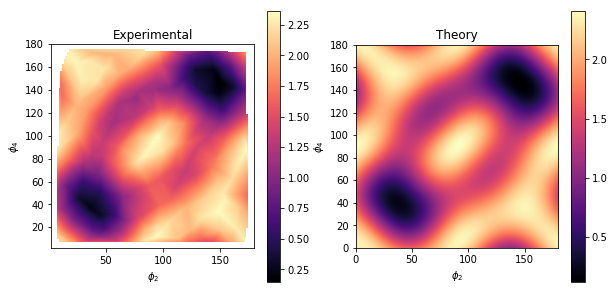

In [46]:
# Muestra ficticia
Jid = np.identity(4)
(p1, p2, delay, th0) = (0.97, 0.97, 46.9*degrees, 94*degrees)
Msample = ps.Mueller_Real_Retarder(p1, p2, delay)
Msample = ps.rotate_mueller(Msample, th0)
#Msample = Jr2
#Msample = ps.rotate_mueller(Msample, 30*degrees)

# Simular experimento teorico
Nxy = 120
th2, th3 = np.linspace(0, pi, Nxy), np.linspace(0, pi, Nxy)
#Mexp = [Jp1, Jr1, Msample, Jr2, Jp2]
#Mexp = [Jp1, Jid, Msample, Jid, Jp2]
#Mexp = [Jid, Jp1, Msample, Jp2, Jid]
Mexp = [Jp1, Jr1, Msample, Jr2, Jp2]
#th_teory = [-th0p1-th0p1ad, th2-th0r1-th0r1ad, 0, th3-th0r2, -th0p2]
th_teory = [0, th2, 0, th3, 0]
Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)

# Generar angulos
N = 200
limits = [0, 180, 180, 0]
Nlimit = [0, 0, 0, 0]
angles = generate_even_distribution(Nmeasures=N, limits=limits, method='linear')
angulos = angles*degrees
# Simular experimento del polarimetro
Iexperiment = np.zeros(N)
for ind in range(N):
    #th_exp = [0-th0p1-th0p1ad, angulos[1, ind]-th0r1-th0r1ad, 0, angulos[2, ind]-th0r2, 0-th0p2]
    th_exp = [angulos[0, ind], angulos[1, ind], 0, angulos[2, ind], angulos[3, ind]]
    Iexperiment[ind] = opsys.Intensity_Rotating_Elements(Mexp, th_exp, Ifuente)

# Analizar experimento del polarimetro
a2 = angulos[1,:]
a3 = angulos[2,:]
a1 = angulos[0,:]
a4 = angulos[3,:]
th1 = np.array([a1, a2, a3, a4])
Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Iexperiment, th1)

# Print results
print('Muestra')
print(Msample)
print('Calculada')
print(Mcalculated)
R_sample = amm.delay(Msample)
R_calculated = amm.delay(Mcalculated)
print("Delays calculados: Muestra = {}; Calculada = {};".format(
    R_sample/degrees, R_calculated/degrees))
# Plot results
plt.figure(figsize=(10, 5))   
plt.subplot(1,2,1)
plot_2d_scattered(a2, a3, Iexperiment, title='Experimental', Nxy=Nxy) 
plt.subplot(1,2,2)
plot_2d(th2/degrees, th3/degrees, Iteory, title='Theory', xy_are_angles=False) 

# Analyze matrices
_, _, _ = amm.decompose_polar(Msample, decomposition='DRP', verbose=True, co=False, tol=0.01, filter=False)
_, _, _ = amm.decompose_polar(Mcalculated, decomposition='DRP', verbose=True, co=False, tol=0.01, filter=False)

In [42]:
print((82.5%pi)/degrees)

46.9018098293


Direct delay measurement: 32.5486151683;
Experiment data:
{'angles origin': [126.94007888766, 184.72733727559998, 2.78054116251, 104.736748578], 'type': 'linear', 'limits': [0, 180, 180, 0]}
Target
[[ 0.9409      0.          0.          0.        ]
 [ 0.          0.84939955 -0.07148799 -0.39837506]
 [ 0.         -0.07148799  0.88504746 -0.3112447 ]
 [ 0.          0.39837506  0.3112447   0.79354701]]
Calculated
[[ 0.94750721 -0.01559282 -0.01228688  0.01199614]
 [ 0.01298899  0.86726311 -0.07216745 -0.40362609]
 [ 0.01259778 -0.07284177  0.88439161 -0.32316413]
 [ 0.00417224  0.38431463  0.30196228  0.79322693]]
The original matrix is:
[[ 0.94750721 -0.01559282 -0.01228688  0.01199614]
 [ 0.01298899  0.86726311 -0.07216745 -0.40362609]
 [ 0.01259778 -0.07284177  0.88439161 -0.32316413]
 [ 0.00417224  0.38431463  0.30196228  0.79322693]]
None condition was violated.
Filtered
[[ 0.94750721 -0.01559282 -0.01228688  0.01199614]
 [ 0.01298899  0.86726311 -0.07216745 -0.40362609]
 [ 0.0125977

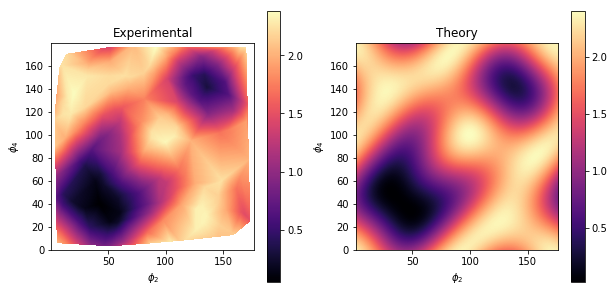

In [53]:
# Load experiment data
#filename = 'Retardador_WQ10E-850-SP_0deg_linear_ret_2018-10-04.npz'
filename = 'Retardador_WQ10E-850-SP_30deg_linear_ret_2018-10-04.npz'
angle_target = (64)*degrees
Mtarget = ps.Mueller_Real_Retarder(0.97, 0.97, 32.5*degrees) # Al menos parecido
Mtarget = ps.rotate_mueller(Mtarget, angle_target)
analyze_angles = False
analyze_results = True
Nxy = 200
data = np.load(filename)
f_normalization = 1.06824173
# np.savez(filename+'.npz', angulos = angles, todos = todos, intensidad=I)
angulos = data['angulos']
#print(angulos)
angulos_deg = angulos*degrees
param = data['parametros']
Intensity = data['intensidad']
Intensity += [0.0371+0.0192, 4.3301-0.0268]
Intensity = clean_intensity(Intensity, mean[1], Nd=1)
Intensity /= f_normalization
# Angles
a2 = angulos_deg[:,1]
a3 = angulos_deg[:,2]
a1 = angulos_deg[:,0]
a4 = angulos_deg[:,3]
th1 = np.array([a1, a2, a3, a4])

# Do the polarimeter experiment
Mcalculated = opsys.polarimeter_experiment(M, Ifuente, Intensity, th1)
print('Direct delay measurement: {};'.format(amm.delay(Mcalculated)/degrees))

# Calculate target and error
error = Mcalculated - Mtarget
error = np.std(error)

# Plot measurements and theoretical comparation (only valid if P1 and P2 don't move)
if analyze_results:
    # Plot experiment
    plt.figure(figsize=(10, 5))   
    plt.subplot(1,2,1)
    plot_2d_scattered(a2, a3, Intensity, 
                      title='Experimental', Nxy=Nxy) 
    # Calculate the theoretical result
    th2, th3 = np.linspace(a2.min(), a2.max(), Nxy), np.linspace(a3.min(), a3.max(), Nxy)
    Mexp = [Jp1, Jr1, Mtarget, Jr2, Jp2]
    th_teory = [0, th2, 0, th3, 0]
    Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)
    # Plot theory 
    plt.subplot(1,2,2)
    plot_2d(th2/degrees, th3/degrees, Iteory, title='Theory', xy_are_angles=False)  
    

print('Experiment data:')
print(param)
print('Target')
print(Mtarget)
print('Calculated')
print(Mcalculated)
    
# Filter and calculate again
Mfiltered = amm.filter_reality_conditions(Mcalculated, tol=0.02, verbose=True)
error2 = Mfiltered - Mtarget
error2 = np.std(error2)

# Print result and compare with the theoretical one
print('Filtered')
print(Mfiltered)
print('Error: {}; Error tras filtrar: {};'.format(error, error2))

# Try to extract meaning from the matrix
amm.all_parameters(Mfiltered)
#_, _, _ = amm.decompose_polar(Mfiltered, decomposition='DRP', verbose=True, co=False, tol=0.001, filter=False)
_, _ = amm.decompose_pure(Mfiltered, right=True, verbose=True, co=False, tol=0.01)

In [ ]:
# Datos experimentales
filename = 'Retardador_WQ10E-850-SP_0deg_linear_ret_2018-10-04.npz'

# Muestra ficticia
(p1, p2, delay, th0) = (0.97, 0.97, 46.9*degrees, 94*degrees)
#Msample = Jr2
#Msample = ps.rotate_mueller(Msample, 30*degrees)
# Rotation angles
Nxy = 120
th2, th3 = np.linspace(0, pi, Nxy), np.linspace(0, pi, Nxy)
th_teory = [0, th2, 0, th3, 0]
# Desfases a probar
ret_angles = np.linspace(0,90,10)*degrees

# Loop para probar los diferentes retardos
for ind, ret_value in enumerate(ret_angles):    
    Msample = ps.Mueller_Real_Retarder(p1, p2, delay)
    Msample = ps.rotate_mueller(Msample, th0)
    Mexp = [Jp1, Jr1, Msample, Jr2, Jp2]
    Iteory = opsys.Intensity_Rotating_Elements(Mexp, th_teory, Ifuente)

# Plot results
plt.figure(figsize=(6, 6)) 
plot_2d_scattered(a2, a3, Intensity, 
                  title='Experimental', Nxy=300) 


## Conclusion

En realidad el desfase dado por thorlabs es 37º, era para 405 nm.

In [54]:
# Delay from specifications
a = 1.07359
b1 = -0.00195
b2 = 1.541e-6
b3 = -4.52e-10
lda = 405
result = a + b1*lda + b2*lda**2 + b3*lda**3
print(result*360)

182.36739906
